In [22]:

import os
import shutil
import cv2

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from tqdm import tqdm

import keras
from keras.callbacks import EarlyStopping,ModelCheckpoint

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder
# from imblearn.over_sampling import SMOTE

In [2]:
import os
import zipfile
from google.colab import drive

drive.mount('/content/drive')
filename = 'smallpreprocessed.zip'
with zipfile.ZipFile( os.path.join('/content/drive/MyDrive', filename), 'r') as zip_ref:
    zip_ref.extractall(f'{filename}_extracted')

Mounted at /content/drive


In [3]:
dataset_dir = '/content/smallpreprocessed.zip_extracted/data/SmallPreprocessed'
image_size = (224, 224)
batch_size = 32

datagen = ImageDataGenerator(
    preprocessing_function= tf.keras.applications.resnet.preprocess_input,
    rescale=1./255
)

train_generator = datagen.flow_from_directory(
    os.path.join(dataset_dir, 'train'),
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

test_generator = datagen.flow_from_directory(
    os.path.join(dataset_dir, 'test'),
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

val_generator = datagen.flow_from_directory(
    os.path.join(dataset_dir, 'val'),
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = True
)

Found 12000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


In [15]:
class_num = list(train_generator.class_indices.keys())
class_num

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [4]:
model = keras.models.Sequential()
model.add(
    tf.keras.applications.VGG16(
        input_shape = (image_size[0], image_size[1], 3),
        include_top = False,
        pooling = 'avg',
        weights = 'imagenet'))

model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(2048, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(4, activation='softmax'))
model.layers[0].trainable = False

# Build the model with the correct input shape
model.build(input_shape=(None, image_size[0], image_size[1], 3))
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,881,924 (68.21 MB)

 Trainable params: 3,160,068 (12.05 MB)

 Non-trainable params: 14,721,856 (56.16 MB)

In [5]:
checkpoint_cb = ModelCheckpoint(
    "model_VGG16.keras",
    save_best_only = True)

early_stopping_cb = EarlyStopping(
    patience = 10,
    restore_best_weights = True
)

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [6]:
EPOCHS = 20

In [7]:
hist = model.fit(
    train_generator,
    epochs = EPOCHS,
    validation_data = val_generator,
    callbacks = [checkpoint_cb, early_stopping_cb]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


375/375 ━━━━━━━━━━━━━━━━━━━━ 91s 204ms/step - accuracy: 0.6536 - loss: 1.2156 - val_accuracy: 0.6990 - val_loss: 0.6849
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 72s 192ms/step - accuracy: 0.8382 - loss: 0.4155 - val_accuracy: 0.8480 - val_loss: 0.3904
Epoch 3/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 75s 201ms/step - accuracy: 0.8892 - loss: 0.3007 - val_accuracy: 0.8730 - val_loss: 0.3352
Epoch 4/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 76s 202ms/step - accuracy: 0.9189 - loss: 0.2263 - val_accuracy: 0.9090 - val_loss: 0.2532
Epoch 5/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 82s 201ms/step - accuracy: 0.9340 - loss: 0.1777 - val_accuracy: 0.9035 - val_loss: 0.2838
Epoch 6/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 77s 206ms/step - accuracy: 0.9456 - loss: 0.1510 - val_accuracy: 0.9270 - val_loss: 0.2137
Epoch 7/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 91s 231ms/step - accuracy: 0.9478 - loss: 0.1513 - val_accuracy: 0.9115 - val_loss: 0.2761
Epoch 8/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 77s 205ms/step - accuracy: 0.9534 - loss: 0.1367 - val

In [29]:
temp_dir = os.path.join('/content/', 'models', 'VGG16')

shutil.rmtree(temp_dir, ignore_errors = True)
os.makedirs(temp_dir, exist_ok = True)

model.save(os.path.join(temp_dir, 'vgg16_model.keras'))
model.export(os.path.join(temp_dir, 'vgg16_model'))

def zipdir(src_path: str, ziph_object: zipfile.ZipFile):
    for root, dirs, files in os.walk(src_path):
        for file in files:
            file_path = os.path.join(root, file)
            arcname = os.path.relpath(file_path, src_path)
            ziph_object.write(file_path, arcname)


with zipfile.ZipFile('vgg16_model.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipdir(temp_dir, zipf)

shutil.copy2(
    'vgg16_model.zip',
    os.path.join('/content/drive/MyDrive', 'vgg16_model.zip'))

shutil.rmtree(temp_dir, ignore_errors = True)
os.remove('vgg16_model.zip')

Saved artifact at '/content/models/VGG16/vgg16_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_20')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  138236415120336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138236415121104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138236383530640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138236383529680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138236383531216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138236383530064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138236383530832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138236383531408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138236383530256: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138236383533328: TensorSpec(shape=(), dtype=tf.resource, name=No

In [10]:
score, acc= model.evaluate(test_generator)
print('Val Loss =', score)
print('Val Accuracy =', acc)

63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.9625 - loss: 0.1449
Val Loss = 0.220563143491745
Val Accuracy = 0.9440000057220459


In [11]:
hist_=pd.DataFrame(hist.history)

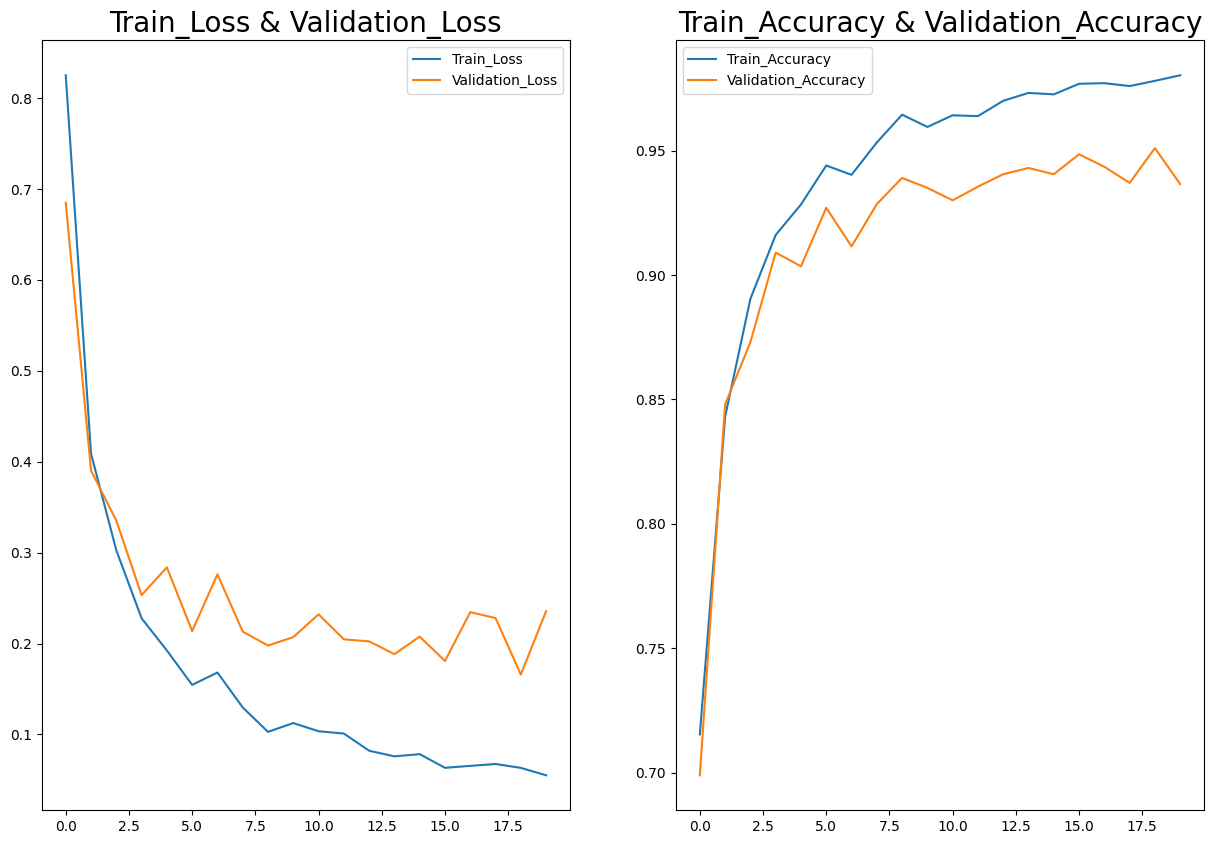

In [12]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.show()

In [13]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions,axis=1)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})

63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 212ms/step


array([[484,   4,   3,   9],
       [  3, 497,   0,   0],
       [ 12,   0, 458,  30],
       [ 24,   5,  22, 449]])

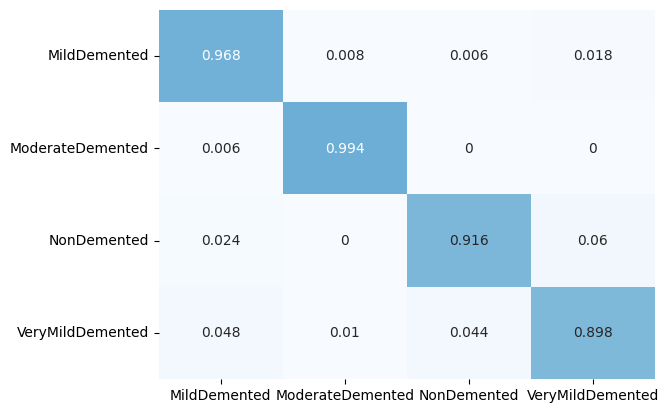

In [16]:
CM = confusion_matrix(y_test,y_pred)
CM_percent = CM.astype('float') / CM.sum(axis=1)[:, np.newaxis]
sns.heatmap(CM_percent,fmt='g',center = True,cbar=False,annot=True,cmap='Blues',xticklabels=class_num, yticklabels=class_num)
CM

In [17]:
ClassificationReport = classification_report(y_test,y_pred,target_names=class_num)
print('Classification Report is : ', ClassificationReport)

Classification Report is :                    precision    recall  f1-score   support

    MildDemented       0.93      0.97      0.95       500
ModerateDemented       0.98      0.99      0.99       500
     NonDemented       0.95      0.92      0.93       500
VeryMildDemented       0.92      0.90      0.91       500

        accuracy                           0.94      2000
       macro avg       0.94      0.94      0.94      2000
    weighted avg       0.94      0.94      0.94      2000

